In [99]:
from vit_pytorch.recorder import Recorder
from vit_pytorch import ViT
import torch
from dataset import ImageDataset
from torch.utils.data import DataLoader
from scripts.model import *

In [100]:
img_dir = 'casting_data'
annotations_file = 'casting_data/annotations.csv'

BATCH_SIZE = 32
num_epochs = 5

ds_train = ImageDataset(annotations_file=annotations_file, img_dir=img_dir, set_type='train')
ds_test = ImageDataset(annotations_file=annotations_file, img_dir=img_dir, set_type='test')
  
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

In [101]:
image_size = 256
patch_size = 32
num_classes = 2
dim = 4
depth = 4
heads = 4
mlp_dim = 128
dropout = 0.01
emb_dropout = 0.01
 
model_config = {
  'image_size' : image_size,
  'patch_size' : patch_size,
  'num_classes' : num_classes,
  'dim' : dim,
  'depth' : depth,
  'heads' : heads,
  'mlp_dim' : mlp_dim,
  'dropout' : dropout,
  'emb_dropout' : emb_dropout
  }
 
model = ViT(image_size = image_size,
            patch_size = patch_size,
            num_classes = num_classes,
            dim = dim,
            depth = depth,
            heads = heads,
            mlp_dim = mlp_dim,
            dropout = dropout,
            emb_dropout = emb_dropout)

In [102]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)
 
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
 
results = train(model=model,
                train_dataloader=dl_train,
                test_dataloader=dl_test,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=num_epochs,
                device='cpu')

39814


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6654 | train_acc: 0.5923 | test_loss: 0.6369 | test_acc: 0.6466
Epoch: 2 | train_loss: 0.6240 | train_acc: 0.6584 | test_loss: 0.6066 | test_acc: 0.6937
Epoch: 3 | train_loss: 0.5928 | train_acc: 0.6918 | test_loss: 0.5965 | test_acc: 0.6784
Epoch: 4 | train_loss: 0.5509 | train_acc: 0.7286 | test_loss: 0.5042 | test_acc: 0.7694
Epoch: 5 | train_loss: 0.5070 | train_acc: 0.7637 | test_loss: 0.4907 | test_acc: 0.7763


In [103]:
from vit_pytorch.recorder import Recorder
model = Recorder(model)

In [157]:
img_idx = 220
img = dl_test.dataset.__getitem__(img_idx)[0]
img = img.reshape(1, 3, image_size, image_size)
preds, attns = model(img)

In [178]:
last_layer = attns[0][3][0]
last_layer.shape

torch.Size([65, 65])

In [179]:
import torch.nn.functional as F
attn_heatmap = last_layer[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
print("attn_heatmap: ", attn_heatmap.shape)
attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear')
print("attn_heatmap_resized: ", attn_heatmap_resized.shape)

attn_heatmap:  torch.Size([8, 8])
attn_heatmap_resized:  torch.Size([1, 1, 256, 256])


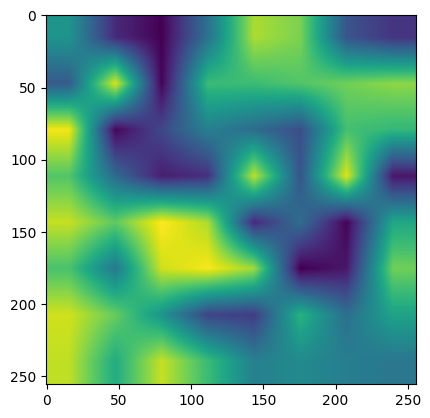

In [180]:
import matplotlib.pyplot as plt
plt.imshow(attn_heatmap_resized[0][0].detach().cpu().numpy())

C:\Users\andre\AppData\Local\Temp\ipykernel_17000\3294325.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(attn_combined).unsqueeze(0),


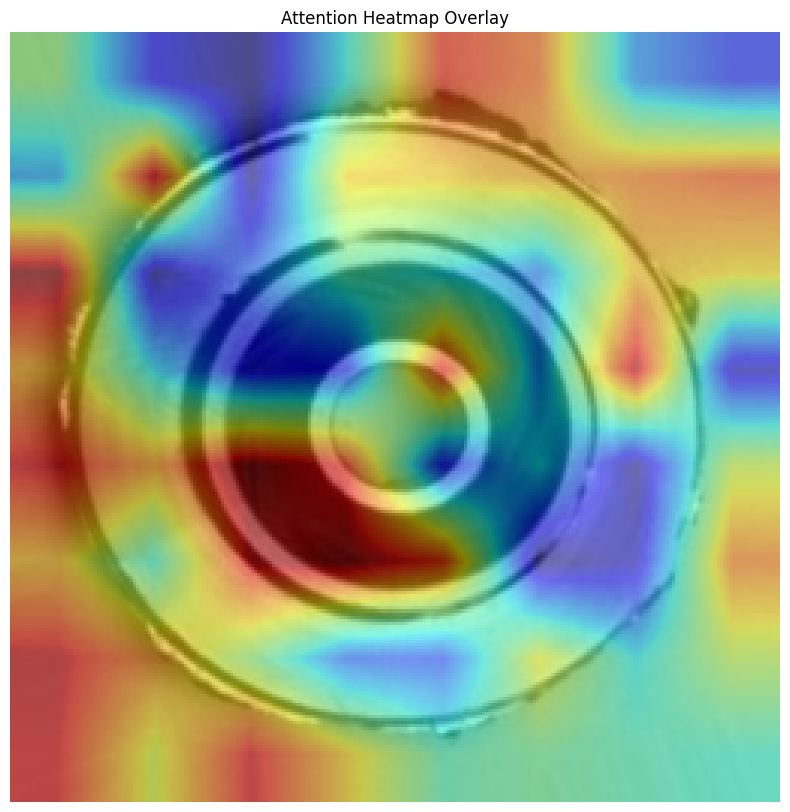

In [181]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T

batch, layers, heads, patch_x, patch_y = attns.shape


attn_combined = attns.mean(dim=2).sum(dim=0)[3]

attn_image = T.functional.resize(
    torch.tensor(attn_combined).unsqueeze(0),  
    (image_size, image_size),
    interpolation=T.InterpolationMode.BILINEAR
)
attn_image = attn_image.squeeze().numpy()
attn_image = attn_heatmap_resized[0][0].numpy()

img_np = img[0].permute(1, 2, 0).numpy()

img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

plt.figure(figsize=(10, 10))
plt.imshow(img_np)
plt.imshow(attn_image, cmap='jet', alpha=0.5)  
plt.axis('off')
plt.title("Attention Heatmap Overlay")
plt.show()